<a href="https://colab.research.google.com/github/Snaiyer1/MAT_421/blob/main/ModuleH2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Numerical Error and Instability

There are two main issues to consider with regard to integration schemes for ODEs: **accuracy** and **stability**.

- **Accuracy** refers to a scheme’s ability to approximate the exact solution based on the step size $h$. It is usually denoted as \( O(h^p) \).
- **Stability** refers to the scheme's ability to prevent errors from growing over time. If the error does not grow, the method is **stable**; otherwise, it is **unstable**.

We will illustrate these issues by numerically solving the pendulum equation using the euler explicit method, euler implicit method, and trapezoidal method.

Lets solve the pendulum ODE over the time interval $[0, 5]$ with a step size of $h = 0.1$, initial condition $Theta(0) = 1$, and angular velocity $dot{\Theta}(0) = 0$. We'll use $sqrt{g/l} = 4$.

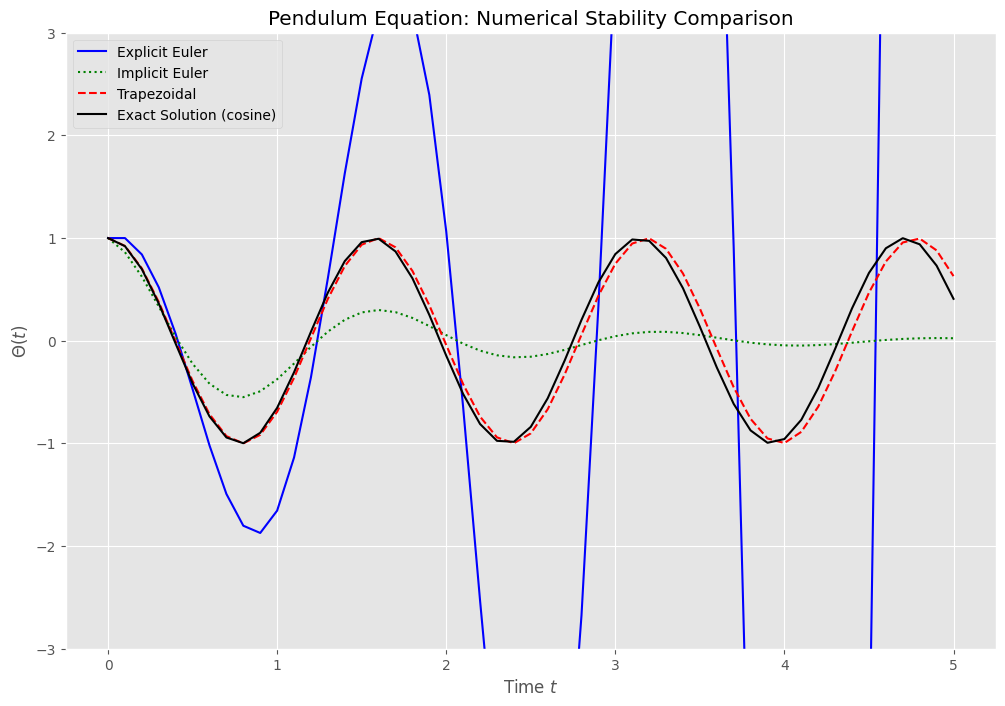

In [2]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

h = 0.1
t = np.arange(0, 5.1, h)
w = 4
s0 = np.array([[1], [0]])

m_e = np.array([[1, h],
                [-w**2*h, 1]])
m_i = inv(np.array([[1, -h],
                    [w**2*h, 1]]))
m_t = np.dot(inv(np.array([[1, -h/2],
                           [w**2*h/2, 1]])),
             np.array([[1, h/2],
                       [-w**2*h/2, 1]]))

s_e = np.zeros((len(t), 2))
s_i = np.zeros((len(t), 2))
s_t = np.zeros((len(t), 2))

s_e[0, :] = s0.T
s_i[0, :] = s0.T
s_t[0, :] = s0.T

for j in range(len(t) - 1):
    s_e[j+1, :] = np.dot(m_e, s_e[j, :])
    s_i[j+1, :] = np.dot(m_i, s_i[j, :])
    s_t[j+1, :] = np.dot(m_t, s_t[j, :])

plt.figure(figsize=(12, 8))
plt.plot(t, s_e[:, 0], 'b-', label='Explicit Euler')
plt.plot(t, s_i[:, 0], 'g:', label='Implicit Euler')
plt.plot(t, s_t[:, 0], 'r--', label='Trapezoidal')
plt.plot(t, np.cos(w*t), 'k', label='Exact Solution (cosine)')

plt.ylim([-3, 3])
plt.xlabel('Time $t$')
plt.ylabel(r'$\Theta(t)$')
plt.title('Pendulum Equation: Numerical Stability Comparison')
plt.legend()
plt.grid(True)
plt.show()


The **Explicit Euler** method diverges and becomes unstable quickly. The **Implicit Euler** method is stable but exhibits **artificial damping**, causing the amplitude to decay incorrectly. The **Trapezoidal** method performs best: it remains stable and closely follows the true solution (cosine wave), although with a slight phase error.

This example highlights how **stability** and **accuracy** differ between integration methods, and why method selection is critical for solving ODEs reliably.

###Predictor-Corrector and Runge Kutta Methods

Given any time and state value, the function $F(t, S(t))$ returns the change of state $\frac{dS(t)}{dt}$. Predictor-corrector methods of solving initial value problems improve the approximation accuracy of non-predictor-corrector methods by querying the $F$ function several times at different locations (predictions), and then using a weighted average of the results (corrections) to update the state. Essentially, it uses two formulas: the predictor and the corrector. The predictor is an explicit formula and first estimates the solution at $t_{j+1}$. For example, using Euler’s method. After we obtain the solution $S(t_{j+1})$, we apply the corrector to improve the accuracy. Using the found $S(t_{j+1})$ on the right-hand side of an otherwise implicit formula, the corrector can calculate a new, more accurate solution.

The midpoint method has a predictor step which is the prediction of the solution value halfway between $t_j$ and $t_{j+1}$. It then computes the corrector step, which computes the solution at $S(t_{j+1})$ from $S(t_j)$ using the derivative from $S(t_j + \frac{h}{2})$.

Runge-Kutta (RK) methods are among the most widely used methods for solving ODEs. Recall that the Euler method uses the first two terms in the Taylor series to approximate numerical integration, which is linear. We can greatly improve the accuracy if we retain more terms of the series. To get this more accurate solution, we would need to derive the expressions of $S''(t_j)$, $S'''(t_j)$, ..., $S^{(n)}(t_j)$. However, this extra work can be avoided using RK methods, which are based on truncated Taylor series but do not require computation of higher-order derivatives.

Assume $\frac{dS(t)}{dt} = F(t, S(t))$. Then we propose an integration formula of the form $$S(t+h) = S(t) + c_1 F(t, S(t)) h + c_2 F\left(t + p h, S(t) + q h F(t, S(t))\right) h$$

We aim to find parameters $c_1$, $c_2$, $p$, and $q$ by matching to the second-order Taylor series $$S(t+h) = S(t) + F(t, S(t))h + \frac{1}{2} F'(t, S(t)) h^2$$

Noting that $$F'(t, S(t)) = \frac{\partial F}{\partial t} + \frac{\partial F}{\partial S} \frac{dS}{dt} = \frac{\partial F}{\partial t} + \frac{\partial F}{\partial S} F$$

So $$S(t+h) = S + Fh + \frac{1}{2} \left(\frac{\partial F}{\partial t} + \frac{\partial F}{\partial S} F \right) h^2$$

Meanwhile, expanding the second term in our assumed formula $$F\left(t+ph, S+qhF\right) = F + \frac{\partial F}{\partial t} ph + qh \frac{\partial F}{\partial S} F$$

Substitute back in $$S(t+h) = S + (c_1 + c_2) Fh + c_2 \left(p \frac{\partial F}{\partial t} + q \frac{\partial F}{\partial S} F \right) h^2$$

Comparing with the earlier expansion gives us $$c_1 + c_2 = 1, \quad c_2 p = \frac{1}{2}, \quad c_2 q = \frac{1}{2}$$

With three equations and four unknowns, we can choose one parameter freely. A common choice is $$c_1 = \frac{1}{2}, \quad c_2 = \frac{1}{2}, \quad p = 1, \quad q = 1$$

Define $$k_1 = F(t_j, S_j), \quad k_2 = F(t_j + p h, S_j + q h k_1)$$

Then $$S_{j+1} = S_j + \frac{1}{2}(k_1 + k_2) h$$

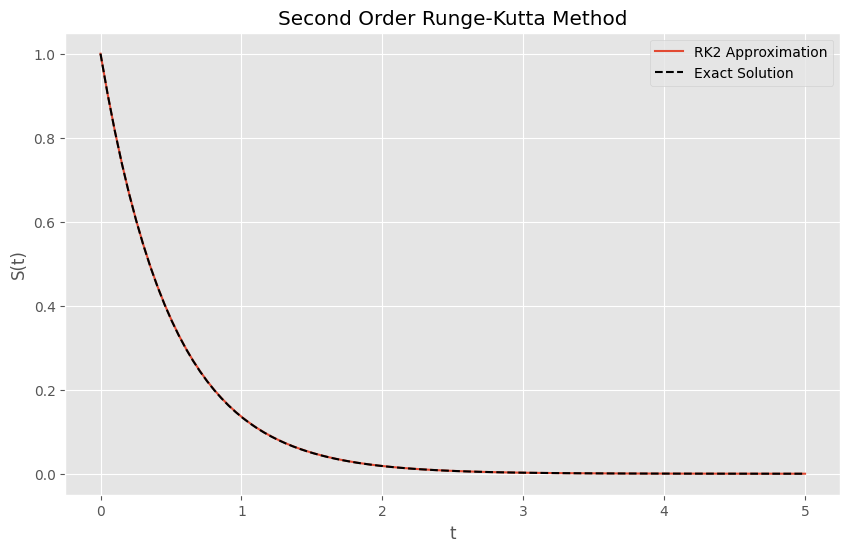

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def F(t, S):
    return -2 * S

def RK2(f, S0, t):
    h = t[1] - t[0]
    S = np.zeros(len(t))
    S[0] = S0
    for i in range(0, len(t) - 1):
        k1 = f(t[i], S[i])
        k2 = f(t[i] + h, S[i] + h * k1)
        S[i+1] = S[i] + 0.5 * (k1 + k2) * h
    return S

t = np.linspace(0, 5, 100)
S_rk2 = RK2(F, 1, t)
S_exact = np.exp(-2 * t)

plt.figure(figsize=(10, 6))
plt.plot(t, S_rk2, label='RK2 Approximation')
plt.plot(t, S_exact, 'k--', label='Exact Solution')
plt.title('Second Order Runge-Kutta Method')
plt.xlabel('t')
plt.ylabel('S(t)')
plt.legend()
plt.grid(True)
plt.show()


A classical method with high accuracy is the Fourth Order Runge-Kutta (RK4) method. It uses four intermediate points $k_1$, $k_2$, $k_3$, and $k_4$. A weighted average of these is used to produce the final approximation $$ \begin{align*}
k_1 &= F(t_j, S_j) \\
k_2 &= F\left(t_j + \frac{h}{2}, S_j + \frac{h}{2} k_1\right) \\
k_3 &= F\left(t_j + \frac{h}{2}, S_j + \frac{h}{2} k_2\right) \\
k_4 &= F\left(t_j + h, S_j + h k_3\right)
\end{align*}$$

Therefore $$ S_{j+1} = S_j + \frac{h}{6} (k_1 + 2k_2 + 2k_3 + k_4) $$

As indicated by its name, the RK4 method is fourth-order accurate, or $O(h^4)$.


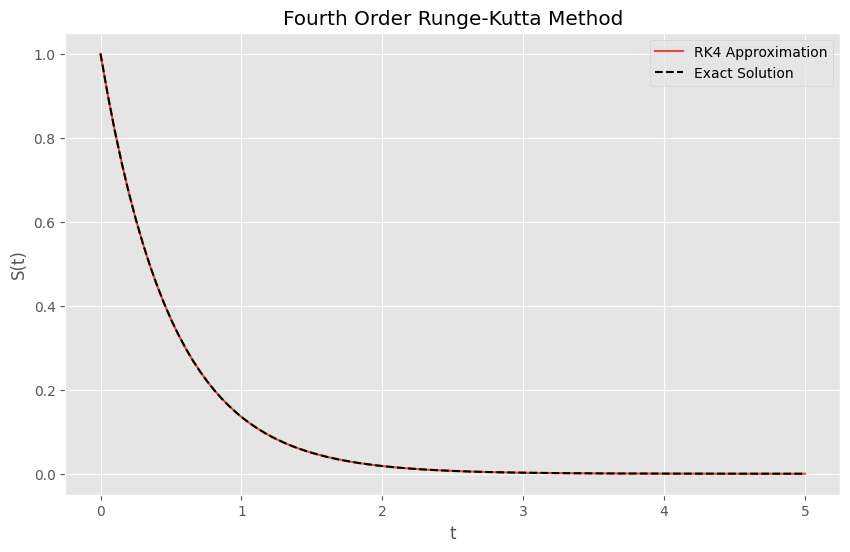

In [4]:
def RK4(f, S0, t):
    h = t[1] - t[0]
    S = np.zeros(len(t))
    S[0] = S0
    for i in range(0, len(t) - 1):
        k1 = f(t[i], S[i])
        k2 = f(t[i] + h/2, S[i] + h/2 * k1)
        k3 = f(t[i] + h/2, S[i] + h/2 * k2)
        k4 = f(t[i] + h, S[i] + h * k3)
        S[i+1] = S[i] + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    return S

S_rk4 = RK4(F, 1, t)

plt.figure(figsize=(10, 6))
plt.plot(t, S_rk4, label='RK4 Approximation')
plt.plot(t, S_exact, 'k--', label='Exact Solution')
plt.title('Fourth Order Runge-Kutta Method')
plt.xlabel('t')
plt.ylabel('S(t)')
plt.legend()
plt.grid(True)
plt.show()
